In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Initialize Spark session
spark = SparkSession.builder \
    .appName("RUL Prediction") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Load datasets
train_path = "train_FD002_processed.csv"  # Replace with the correct path
test_path = "test_FD002_processed.csv"  # Replace with the correct path
train_df = spark.read.csv(train_path, header=True, inferSchema=True)
test_df = spark.read.csv(test_path, header=True, inferSchema=True)

# Display schemas
train_df.printSchema()
test_df.printSchema()

# Preprocessing: Assemble features
feature_columns = [col for col in train_df.columns if col not in ("unit_number", "time_in_cycles", "RUL")]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Assemble features and scale them
train_assembled = assembler.transform(train_df).select(col("features"), col("RUL").alias("label"))
test_assembled = assembler.transform(test_df).select(col("features"), col("true_RUL").alias("label"))

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(train_assembled)
train_scaled = scaler_model.transform(train_assembled).select(col("scaledFeatures").alias("features"), col("label"))
test_scaled = scaler_model.transform(test_assembled).select(col("scaledFeatures").alias("features"), col("label"))

# Define models
models = {
    "DecisionTree": DecisionTreeRegressor(featuresCol="features", labelCol="label"),
    "RandomForest": RandomForestRegressor(featuresCol="features", labelCol="label"),
    "GradientBoosting": GBTRegressor(featuresCol="features", labelCol="label"),
}

# Train and evaluate each model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    fitted_model = model.fit(train_scaled)
    predictions = fitted_model.transform(test_scaled)
    rmse = evaluator.evaluate(predictions)
    results[model_name] = rmse
    print(f"{model_name} RMSE: {rmse}")

# Hyperparameter tuning for the best model
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

if best_model_name == "RandomForest":
    param_grid = ParamGridBuilder() \
        .addGrid(best_model.numTrees, [10, 50]) \
        .addGrid(best_model.maxDepth, [5, 10]) \
        .build()
elif best_model_name == "GradientBoosting":
    param_grid = ParamGridBuilder() \
        .addGrid(best_model.maxDepth, [3, 5]) \
        .addGrid(best_model.maxIter, [10, 20]) \
        .build()
else:
    param_grid = ParamGridBuilder() \
        .addGrid(best_model.maxDepth, [5, 10]) \
        .build()

crossval = CrossValidator(estimator=best_model,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)

print(f"Tuning {best_model_name}...")
cv_model = crossval.fit(train_scaled)
cv_predictions = cv_model.transform(test_scaled)
final_rmse = evaluator.evaluate(cv_predictions)

print(f"Best {best_model_name} RMSE after tuning: {final_rmse}")


root
 |-- unit_number: integer (nullable = true)
 |-- time_in_cycles: integer (nullable = true)
 |-- op_setting_1: double (nullable = true)
 |-- op_setting_2: double (nullable = true)
 |-- op_setting_3: double (nullable = true)
 |-- sensor_measurement_1: double (nullable = true)
 |-- sensor_measurement_2: double (nullable = true)
 |-- sensor_measurement_3: double (nullable = true)
 |-- sensor_measurement_4: double (nullable = true)
 |-- sensor_measurement_5: double (nullable = true)
 |-- sensor_measurement_6: double (nullable = true)
 |-- sensor_measurement_7: double (nullable = true)
 |-- sensor_measurement_8: double (nullable = true)
 |-- sensor_measurement_9: double (nullable = true)
 |-- sensor_measurement_10: double (nullable = true)
 |-- sensor_measurement_11: double (nullable = true)
 |-- sensor_measurement_12: double (nullable = true)
 |-- sensor_measurement_13: double (nullable = true)
 |-- sensor_measurement_14: double (nullable = true)
 |-- sensor_measurement_15: double (nul

In [18]:
# Define additional evaluators for MAE and R2
mae_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

# Train and evaluate each model with additional metrics
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    fitted_model = model.fit(train_scaled)
    predictions = fitted_model.transform(test_scaled)

    # Calculate metrics
    rmse = evaluator.evaluate(predictions)
    mae = mae_evaluator.evaluate(predictions)
    r2 = r2_evaluator.evaluate(predictions)

    # Store results
    results[model_name] = {"RMSE": rmse, "MAE": mae, "R2": r2}
    print(f"{model_name} Metrics:")
    print(f"  RMSE: {rmse}")
    print(f"  MAE: {mae}")
    print(f"  R2: {r2}")

# Display the best model based on RMSE
best_model_name = min(results, key=lambda x: results[x]["RMSE"])
print(f"Best model based on RMSE: {best_model_name}")

# Print a summary of all metrics
print("\nModel Performance Summary:")
for model_name, metrics in results.items():
    print(f"{model_name}: RMSE={metrics['RMSE']}, MAE={metrics['MAE']}, R2={metrics['R2']}")


Training DecisionTree...
DecisionTree Metrics:
  RMSE: 39.78333919854146
  MAE: 30.870461019857505
  R2: 0.4527568366891269
Training RandomForest...
RandomForest Metrics:
  RMSE: 33.248588314453535
  MAE: 28.00753120555768
  R2: 0.6177704136684167
Training GradientBoosting...
GradientBoosting Metrics:
  RMSE: 31.910893118472618
  MAE: 24.370220040081886
  R2: 0.6479082913634497
Best model based on RMSE: GradientBoosting

Model Performance Summary:
DecisionTree: RMSE=39.78333919854146, MAE=30.870461019857505, R2=0.4527568366891269
RandomForest: RMSE=33.248588314453535, MAE=28.00753120555768, R2=0.6177704136684167
GradientBoosting: RMSE=31.910893118472618, MAE=24.370220040081886, R2=0.6479082913634497


In [19]:
import os

# Directory to save the model
model_save_path = "best_model"

if os.path.exists(model_save_path):
    print(f"Overwriting existing model at {model_save_path}")
best_model.fit(train_scaled).save(model_save_path)

print(f"Model saved at: {model_save_path}")

from pyspark.ml.regression import GBTRegressionModel, RandomForestRegressionModel, DecisionTreeRegressionModel

if best_model_name == "DecisionTree":
    loaded_model = DecisionTreeRegressionModel.load(model_save_path)
elif best_model_name == "RandomForest":
    loaded_model = RandomForestRegressionModel.load(model_save_path)
elif best_model_name == "GradientBoosting":
    loaded_model = GBTRegressionModel.load(model_save_path)

print(f"Loaded {best_model_name} model from {model_save_path}")


Model saved at: best_model
Loaded GradientBoosting model from best_model


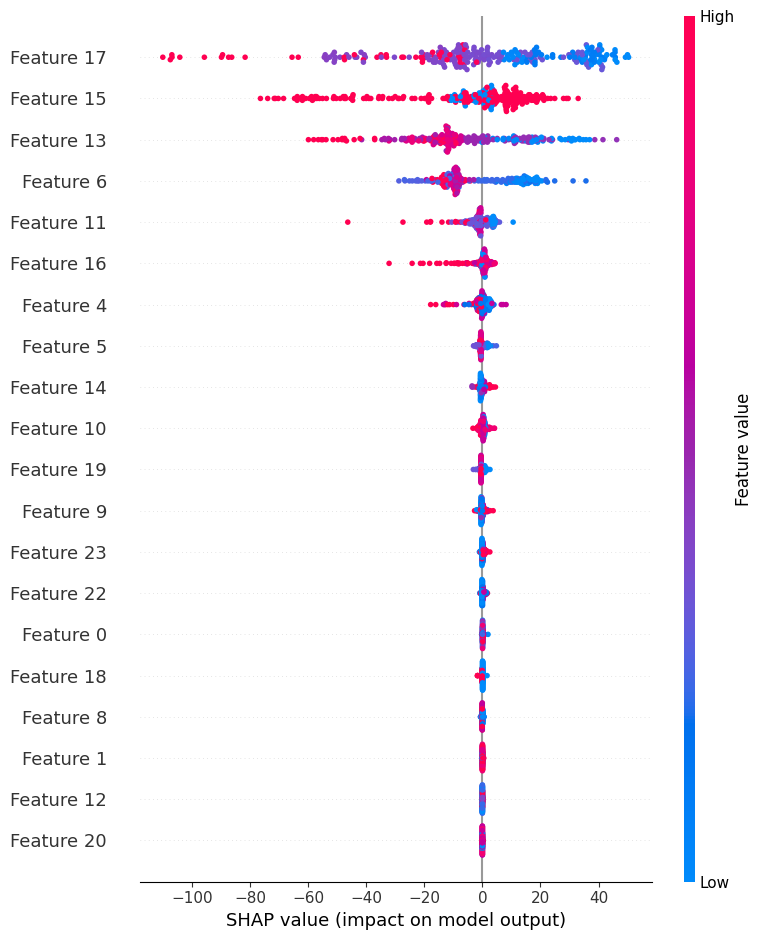

In [21]:
import shap
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

# Convert PySpark features to a structured NumPy array
train_features = np.array([row.features.toArray() for row in train_scaled.collect()])
train_labels = np.array([row.label for row in train_scaled.collect()])
test_features = np.array([row.features.toArray() for row in test_scaled.collect()])

# Train a local Random Forest model
local_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
local_rf.fit(train_features, train_labels)

# Use SHAP to explain predictions
explainer = shap.TreeExplainer(local_rf)
shap_values = explainer.shap_values(test_features)

# Visualize SHAP values (summary plot)
shap.summary_plot(shap_values, test_features)


In [23]:
%pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d44850781619fac550f5d4a85f2b593013b9349026b742321e590abe5acc4601
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [24]:
from lime.lime_tabular import LimeTabularExplainer

# Define feature names (from PySpark DataFrame)
feature_columns = train_df.columns[:-1]  # Exclude the label column

# Create a LIME explainer
explainer = LimeTabularExplainer(
    training_data=train_features,
    mode="regression",
    training_labels=train_labels,
    feature_names=feature_columns,
)

# Explain a single prediction
i = 0  # Index of the sample to explain
explanation = explainer.explain_instance(test_features[i], local_rf.predict)

# Visualize the explanation
explanation.show_in_notebook()  # For Jupyter Notebook


SHAP summary plot saved as shap_summary_plot.png


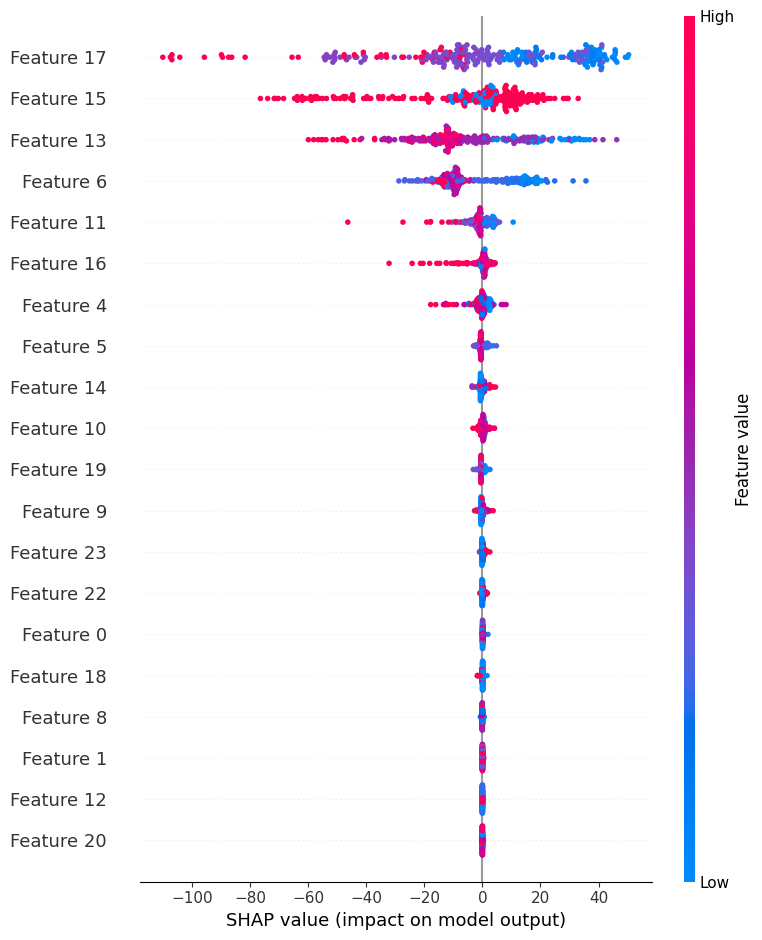

In [25]:
import matplotlib.pyplot as plt

# Save SHAP summary plot as an image
shap.summary_plot(shap_values, test_features, show=False)  # Disable interactive display
plt.savefig("shap_summary_plot.png", bbox_inches='tight')
print("SHAP summary plot saved as shap_summary_plot.png")


LIME explanation saved as lime_explanation.html
LIME explanation plot saved as lime_explanation_plot.png


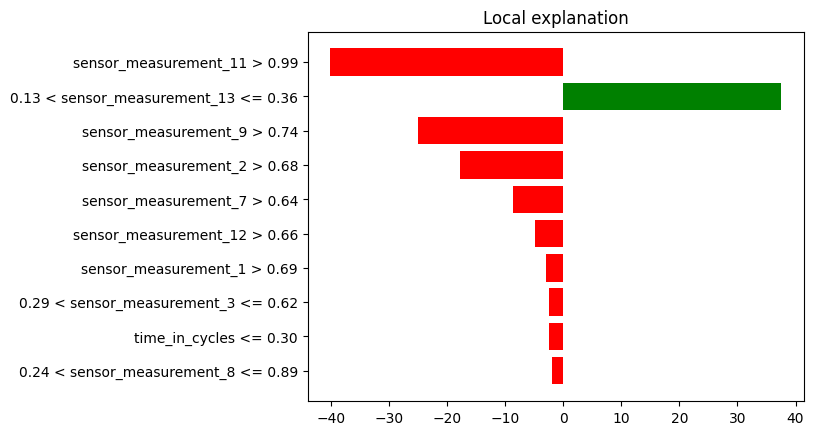

In [26]:
# Save LIME explanation as an image
explanation.save_to_file("lime_explanation.html")  # Save as HTML
print("LIME explanation saved as lime_explanation.html")

# If you prefer an image, you can render it as a figure
fig = explanation.as_pyplot_figure()
fig.savefig("lime_explanation_plot.png", bbox_inches='tight')
print("LIME explanation plot saved as lime_explanation_plot.png")


<ipython-input-27-3b012d8f9bcd>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")
<ipython-input-27-3b012d8f9bcd>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")
<ipython-input-27-3b012d8f9bcd>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")


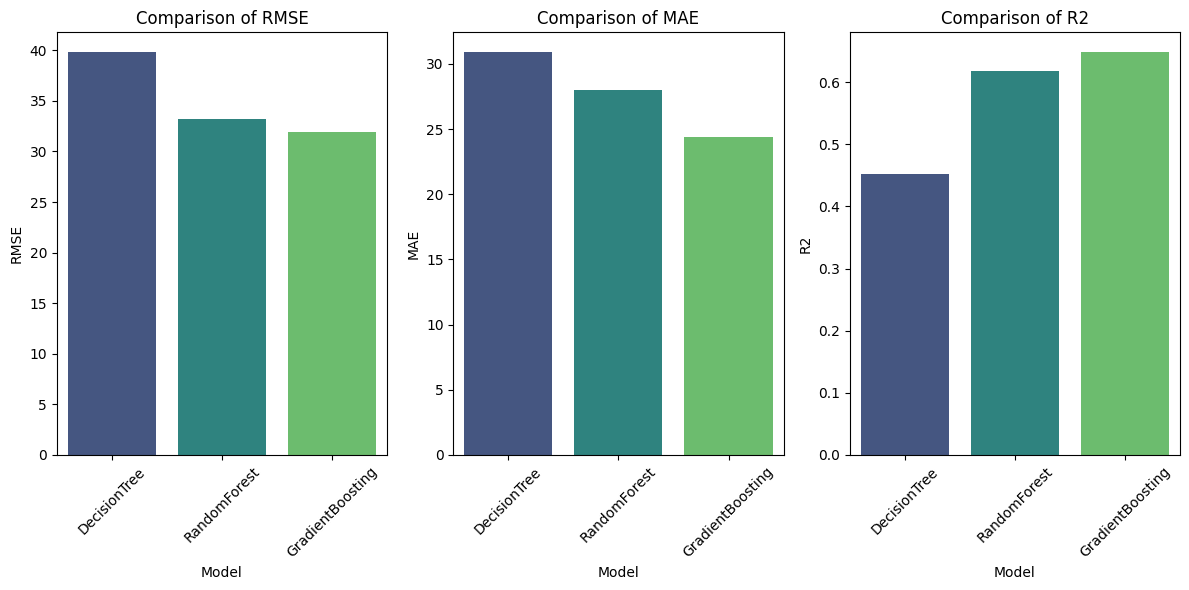

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results dictionary to pandas DataFrame
results_df = pd.DataFrame(results).T  # Transpose to have models as rows
results_df.reset_index(inplace=True)
results_df.rename(columns={"index": "Model"}, inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
metrics = ["RMSE", "MAE", "R2"]

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")
    plt.title(f"Comparison of {metric}")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()
